Copyright (c) 2017 Andrew Johnson, Dan Kotlyar, GTRC

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Results Reader

# # Basic operations

In [105]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import serpentTools
from serpentTools.settings import rc

In [2]:
pathDir = 'C:\\Users\\dkotlyar6\\Dropbox (GaTech)\\Reactor-Simulation-tools\\Serpent Tools\\serpent-tools\\examples\\'
resFile = 'pwrPin_res.m'
res = serpentTools.read(pathDir+resFile)

metadata, such as titles, data paths, etc are present inside the reader 

In [4]:
res.metadata['version']

'Serpent 2.1.29'

In [6]:
res.metadata.keys()

dict_keys(['VERSION', 'COMPILE_DATE', 'DEBUG', 'TITLE', 'CONFIDENTIAL_DATA', 'INPUT_FILE_NAME', 'WORKING_DIRECTORY', 'HOSTNAME', 'CPU_TYPE', 'CPU_MHZ', 'START_DATE', 'COMPLETE_DATE', 'POP', 'CYCLES', 'SKIP', 'BATCH_INTERVAL', 'SRC_NORM_MODE', 'SEED', 'UFS_MODE', 'UFS_ORDER', 'NEUTRON_TRANSPORT_MODE', 'PHOTON_TRANSPORT_MODE', 'GROUP_CONSTANT_GENERATION', 'B1_CALCULATION', 'B1_BURNUP_CORRECTION', 'IMPLICIT_REACTION_RATES', 'OPTIMIZATION_MODE', 'RECONSTRUCT_MICROXS', 'RECONSTRUCT_MACROXS', 'MG_MAJORANT_MODE', 'SPECTRUM_COLLAPSE', 'MPI_TASKS', 'OMP_THREADS', 'MPI_REPRODUCIBILITY', 'OMP_REPRODUCIBILITY', 'SHARE_BUF_ARRAY', 'SHARE_RES2_ARRAY', 'XS_DATA_FILE_PATH', 'DECAY_DATA_FILE_PATH', 'SFY_DATA_FILE_PATH', 'NFY_DATA_FILE_PATH', 'BRA_DATA_FILE_PATH'])

In [5]:
res.metadata['b1Calculation']

[0.0, 0.0, 0.0]

resdata, such as titles, data paths, etc are present inside the reader 

In [7]:
rc['serpentVersion'] in 'Serpent 2.1.29'

True

# # Obtain time-dependent results 

In [60]:
print(res.resdata['absKeff'])  # Values (1st col.) + std (2nd col.) 

[[ 0.991938  0.00145 ]
 [ 0.181729  0.0024  ]]


In [61]:
keff = res.resdata['absKeff'][0:, 0]
bu = res.resdata['burnDays']

<IPython.core.display.Javascript object>


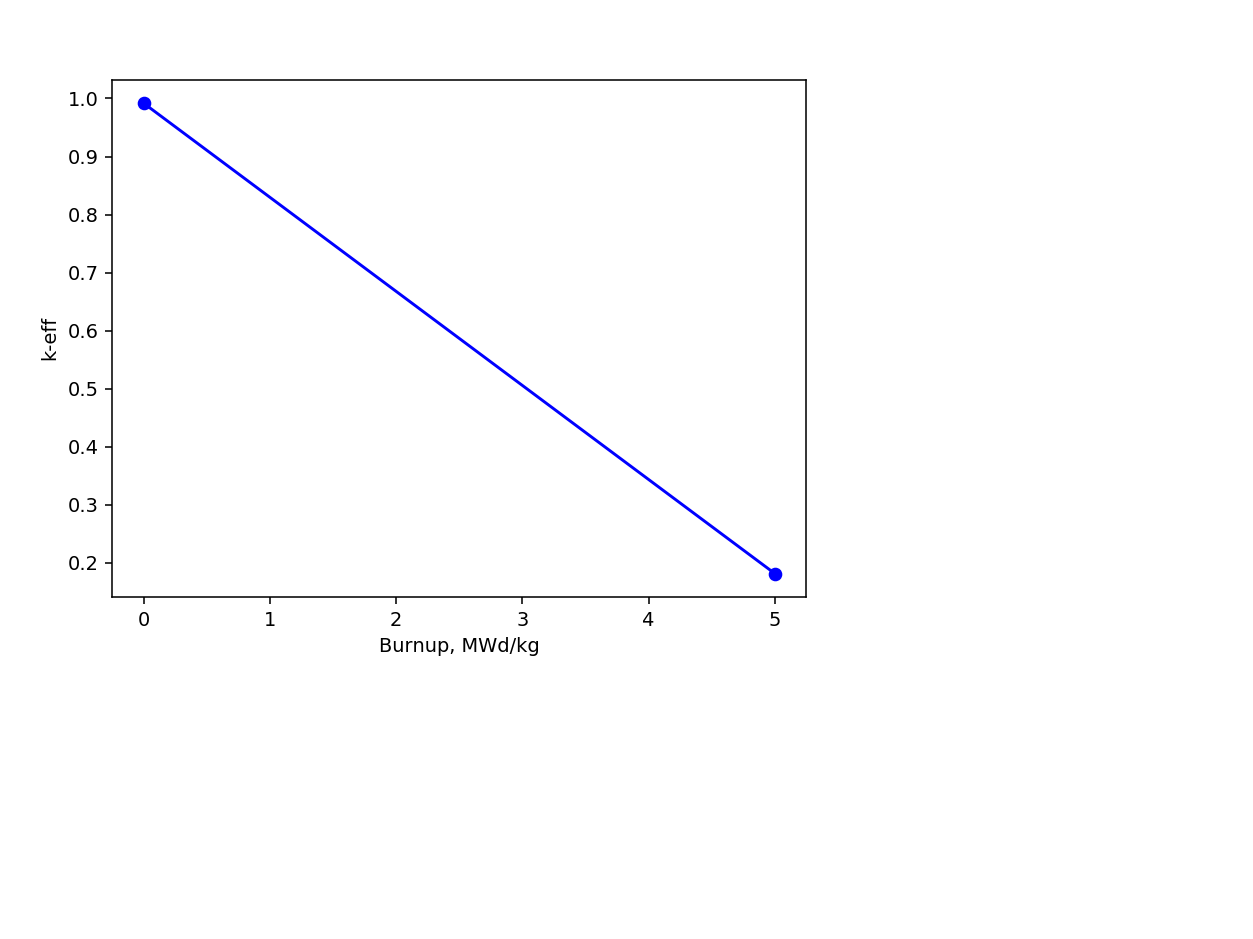

In [62]:
plt.plot(bu, keff, 'bo-')
plt.xlabel('Burnup, MWd/kg')
plt.ylabel('k-eff')

In [59]:
res.resdata.keys()

dict_keys(['minMacroxs', 'dtThresh', 'stFrac', 'dtFrac', 'dtEff', 'reaSamplingEff', 'reaSamplingFail', 'totColEff', 'avgTrackingLoops', 'avgTracks', 'avgRealCol', 'avgVirtCol', 'avgSurfCross', 'lostParticles', 'cycleIdx', 'sourcePopulation', 'meanPopSize', 'meanPopWgt', 'simulationCompleted', 'totCpuTime', 'runningTime', 'initTime', 'processTime', 'transportCycleTime', 'burnupCycleTime', 'batemanSolutionTime', 'mpiOverheadTime', 'estimatedRunningTime', 'cpuUsage', 'transportCpuUsage', 'ompParallelFrac', 'availMem', 'allocMemsize', 'memsize', 'xsMemsize', 'matMemsize', 'resMemsize', 'miscMemsize', 'unknownMemsize', 'unusedMemsize', 'totCells', 'unionCells', 'neutronErgTol', 'neutronErgNe', 'neutronEmin', 'neutronEmax', 'uresDiluCut', 'uresEmin', 'uresEmax', 'uresAvail', 'uresUsed', 'totNuclides', 'totTransportNuclides', 'totDosimetryNuclides', 'totDecayNuclides', 'totPhotonNuclides', 'totReaChannels', 'totTransmuRea', 'useDelnu', 'useUres', 'useDbrc', 'implCapt', 'implNxn', 'implFiss', 

# # Obtain universe-dependent results 

In [63]:
res.univdata

{('0',
  0.0,
  0.0,
  0.0): <serpentTools.objects.containers.HomogUniv at 0x207b4464a20>,
 ('0',
  500.0,
  1.0,
  5.0): <serpentTools.objects.containers.HomogUniv at 0x207b4464cc0>}

The keys of .univdata correspond to a specific state ('universe', burnup, burnupIndex, days)

In [64]:
res.univdata.keys()  # branching states

dict_keys([('0', 0.0, 0.0, 0.0), ('0', 500.0, 1.0, 5.0)])

In [65]:
print(res.univdata[('0', 500, 1, 5)].name)  # universe 
print(res.univdata[('0', 500, 1, 5)].day)   # days
print(res.univdata[('0', 500, 1, 5)].bu)    # burnup
print(res.univdata[('0', 500, 1, 5)].step)  # time-index 

0
5.0
500.0
1.0


In [66]:
len(res.univdata)  # number of state points

2

In [73]:
states = [st for st in res.univdata.keys()]  # obtain all the data points

In [76]:
st0 = res.univdata[states[0]]

In [77]:
st0.infExp['infFlx']  # flux (value +- uncertainy) for each energy

array([  2.46724000e+18,   1.15000000e-03,   2.98999000e+17,
         3.11000000e-03])

In [89]:
st0.metadata['macroE']

array([  1.00000000e+37,   6.25000000e-07,   0.00000000e+00])

In [227]:
absXS = np.array((st0.infExp['infAbs'][0::2], st0.infExp['infAbs'][0::2]))
print(absXS)

[[ 0.010504  0.12326 ]
 [ 0.010504  0.12326 ]]


In [233]:
absXS = absXS.reshape(1, absXS.size)
absXS = np.concatenate((absXS[0, 0::2], absXS[0, 1::2]))
print(absXS)

[ 0.010504  0.010504  0.12326   0.12326 ]


In [242]:
energy = np.concatenate((st0.metadata['macroE'][0:len(st0.metadata['macroE'])-1], st0.metadata['macroE'][1:len(st0.metadata['macroE'])]))

In [250]:
print(energy)
energy[0] = 0.000006

[  6.00000000e-05   6.25000000e-07   6.25000000e-07   0.00000000e+00]


<IPython.core.display.Javascript object>


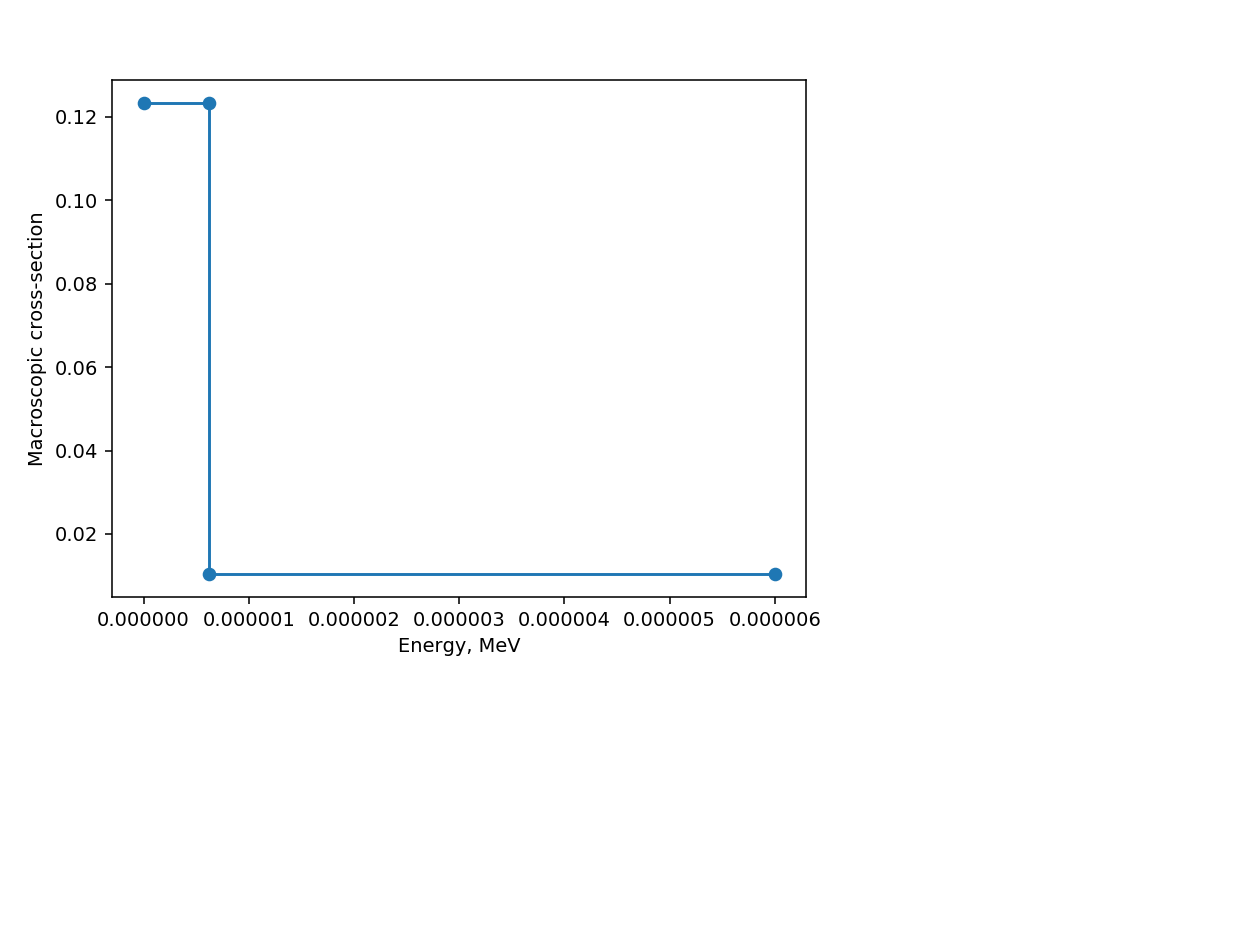

In [251]:
plt.plot(energy, absXS, 'o-')
plt.xlabel('Energy, MeV')
plt.ylabel('Macroscopic cross-section')